## Example: The Darcy flow equation

In this example, the Darcy flow equation is used to model single phase fluid flow through a porous medium. Given an input permeability field, $ a(x) $, and the forcing function, $f(x)$, the output pressure flow $u(x)$ can be calculated using the following equation:
$$
-\nabla\cdot(a(x)\nabla u(x)) = f(x) \qquad x \in (0,1)^2
$$
With Dirchlet boundary conditions: 
$$
u(x) = 0 \qquad x\in \partial(0,1)^2
$$
For this example, the forcing function $f(x) = 1$. 

First, lets import the relevant utilities, including a python script from https://github.com/zongyi-li/fourier_neural_operator/blob/master/data_generation/navier_stokes/random_fields.py that is used to generate Gaussian random functions for the permeability inputs.

In [1]:
import math
import torch
from devito import div, grad, Eq, Operator, TimeFunction, Function, solve, Grid, configuration
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

This is the class used to define a Gaussian random field for the input:

In [2]:
# code edited from  https://github.com/zongyi-li/fourier_neural_operator/blob/master/data_generation/navier_stokes/random_fields.py
class GaussianRF(object):

    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):

        self.dim = dim
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)

            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = torch.randn(N, *self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff
        

        return torch.fft.ifftn(coeff, dim=list(range(-1, -self.dim - 1, -1))).real

Next, lets declare the variables to be used and create a grid for the functions:

In [3]:
# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# number of grid points on [0,1]^2 
s = 256

# create s x s grid with spacing 1
grid = Grid(shape=(s, s), extent=(1.0,1.0))

x, y = grid.dimensions
t = grid.stepping_dim

Here we produce input data to be used as permeability samples. First, the Gaussian random field class is called, then a threshold is introduced, where anything less than 0 is 4 and values above or equal to 0 is 12. This produces permeability samples similar to real world applications. 

In [4]:
# Set up 2d GRF with covariance parameters to generate random coefficients
norm_a = GaussianRF(2, s, alpha=2, tau=3)

#Sample random fields
# create a threshold, either 4 or 12 (common for permeability)
thresh_a = norm_a.sample(1)
thresh_a[thresh_a>=0] = 12
thresh_a[thresh_a<0] = 4

# The input:
w1 = thresh_a[0]

plotting the input:

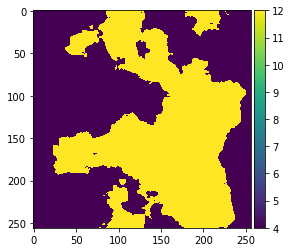

In [5]:
# plot to show the input:
ax = plt.subplot()
im1 = ax.imshow(w1, interpolation='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)
plt.show()

There is no time dependence for this equation, so $ a $ and $ f $ are defined as `function` objects, however the output $u$ is defined as a `Timefunction` object in order to implement a pseudo-timestepping loop, using `u` and `u.forward` as alternating buffers. 

In [6]:
# Forcing function, f(x) = 1 
f = np.ones((s, s))

# create function on grid
# space order of 2 to enable 2nd derivative
# TimeFunction for u can be used despite the lack of a time-dependence. This is done for psuedotime
u = TimeFunction(name='u', grid=grid, space_order=2)
a = Function(name='a', grid=grid, space_order=2)
f1 = Function(name='f1', grid=grid, space_order=2)

Define the equation using symbolic code:

In [7]:
# define 2D Darcy flow equation
equation_u = Eq(-a*u.laplace,f1)

SymPy creates a stencil to reorganise the equation based on `u`, but when creating the update expression, `u.forward` is used in order to stop `u` being overwritten:

In [8]:
# Let SymPy solve for the central stencil point
stencil = solve(equation_u, u)

# Let our stencil populate the buffer `u.forward`
update = Eq(u.forward, stencil)

Define the boundary conditions and create the operator:

In [9]:
# Boundary Conds
nx = s
ny = s
bc = [Eq(u[t+1, 0, y],u[t+1, 1,y])]  # du/dx = 0 for x=0.
bc += [Eq(u[t+1,nx-1, y],u[t+1,nx-2, y])]  # du/dx = 0 for x=1.
bc += [Eq(u[t+1, x, 0],u[t+1,x ,1])]  # du/dx = 0 at y=0
bc += [Eq(u[t+1, x, ny-1],u[t+1, x, ny-2])]  # du/dx=0 for y=1
# u=0 for all sides
bc = [Eq(u[t+1, x, 0], 0.)]
bc += [Eq(u[t+1, x, ny-1], 0.)]
bc += [Eq(u[t+1, 0, y], 0.)]
bc += [Eq(u[t+1, nx-1, y], 0.)]

op = Operator([update] + bc)

Finally, the output is produced using the input data generated:

In [10]:
# a(x) is the coefficients
# f is the forcing function
# give the a and f1 functions the same data as inputs w1 and f

f1.data[:] = f[:]
a.data[:] = w1[:]

Call the operator to produce the output:

In [11]:
# call operator for the 15,000th psuedo-timestep
op(time= 15000)

output = u.data[0]

Plot the output:

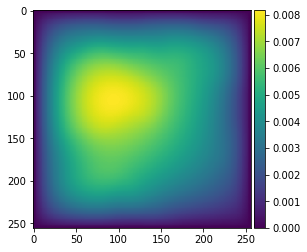

In [12]:
# plot to show the output: 
ax = plt.subplot()
im1 = ax.imshow(output, interpolation='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)
plt.show()

This output shows the flow of pressure given the permeability sample seen above. The results are as expected as a higher pressure is seen in the largest area that contains the lower permeability of 4.